In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import label_binarize
from sklearn import metrics

In [2]:
mpl.rcParams['font.sans-serif'] = [u'SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [3]:
names = [u'Age', u'Number of sexual partners', u'First sexual intercourse',
       u'Num of pregnancies', u'Smokes', u'Smokes (years)',
       u'Smokes (packs/year)', u'Hormonal Contraceptives',
       u'Hormonal Contraceptives (years)', u'IUD', u'IUD (years)', u'STDs',
       u'STDs (number)', u'STDs:condylomatosis',
       u'STDs:cervical condylomatosis', u'STDs:vaginal condylomatosis',
       u'STDs:vulvo-perineal condylomatosis', u'STDs:syphilis',
       u'STDs:pelvic inflammatory disease', u'STDs:genital herpes',
       u'STDs:molluscum contagiosum', u'STDs:AIDS', u'STDs:HIV',
       u'STDs:Hepatitis B', u'STDs:HPV', u'STDs: Number of diagnosis',
       u'STDs: Time since first diagnosis', u'STDs: Time since last diagnosis',
       u'Dx:Cancer', u'Dx:CIN', u'Dx:HPV', u'Dx', u'Hinselmann', u'Schiller',
       u'Citology', u'Biopsy']#df.columns
path = "datas/risk_factors_cervical_cancer.csv"  # 数据文件路径
data = pd.read_csv(path)

In [4]:
X = data[names[0:-4]]
# 这里的Y其实有4个目标属性
Y = data[names[-4:]]
X.head(1)#随机森林可以处理多个目标变量的情况

,Age,Number of sexual partners,First sexual intercourse,Num of pregnancies,Smokes,Smokes (years),Smokes (packs/year),Hormonal Contraceptives,Hormonal Contraceptives (years),IUD,...,STDs:HIV,STDs:Hepatitis B,STDs:HPV,STDs: Number of diagnosis,STDs: Time since first diagnosis,STDs: Time since last diagnosis,Dx:Cancer,Dx:CIN,Dx:HPV,Dx
0,18,4.0,15.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0,?,?,0,0,0,0


In [5]:
#空值的处理
X = X.replace("?", np.NAN)
imputer = Imputer(missing_values="NaN")#使用Imputer给定缺省值，默认的是以mean
X = imputer.fit_transform(X, Y)


C:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [6]:
#数据分割
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.2, random_state=0)
print ("训练样本数量:%d,特征属性数目:%d,目标属性数目:%d" % (x_train.shape[0],x_train.shape[1],y_train.shape[1]))
print ("测试样本数量:%d" % x_test.shape[0])

训练样本数量:686,特征属性数目:32,目标属性数目:4
测试样本数量:172


In [7]:
#标准化
ss = MinMaxScaler()#分类模型，经常使用的是minmaxscaler归一化，回归模型经常用standardscaler
x_train = ss.fit_transform(x_train, y_train)
x_test = ss.transform(x_test)
x_train.shape

(686, 32)

In [8]:
#降维
pca = PCA(n_components=1)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
x_train.shape
print(pca.explained_variance_ratio_)

[0.24021831]


In [9]:
#随机森林模型
forest = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=1, random_state=0)
forest.fit(x_train, y_train)#max_depth一般不宜设置过大，把每个模型作为一个弱分类器

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=1, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [10]:
#模型效果评估
score = forest.score(x_test, y_test)
print ("准确率:%.2f%%" % (score * 100))
#模型预测
forest_y_score = forest.predict_proba(x_test)# prodict_proba输出概率
#计算ROC值
forest_fpr1, forest_tpr1, _ = metrics.roc_curve(label_binarize(y_test[names[-4]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[0].ravel())
forest_fpr2, forest_tpr2, _ = metrics.roc_curve(label_binarize(y_test[names[-3]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[1].ravel())
forest_fpr3, forest_tpr3, _ = metrics.roc_curve(label_binarize(y_test[names[-2]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[2].ravel())
forest_fpr4, forest_tpr4, _ = metrics.roc_curve(label_binarize(y_test[names[-1]],classes=(0,1,2)).T[0:-1].T.ravel(), forest_y_score[3].ravel())
#AUC值
auc1 = metrics.auc(forest_fpr1, forest_tpr1)
auc2 = metrics.auc(forest_fpr2, forest_tpr2)
auc3 = metrics.auc(forest_fpr3, forest_tpr3)
auc4 = metrics.auc(forest_fpr4, forest_tpr4)

print ("Hinselmann目标属性AUC值：", auc1)
print ("Schiller目标属性AUC值：", auc2)
print ("Citology目标属性AUC值：", auc3)
print ("Biopsy目标属性AUC值：", auc4)

准确率:89.53%
Hinselmann目标属性AUC值： 0.9841806381828014
Schiller目标属性AUC值： 0.9497363439697133
Citology目标属性AUC值： 0.9376352082206598
Biopsy目标属性AUC值： 0.9520686857760952


In [11]:
# label_binarize(y_test[names[-4]],classes=(0,1,2)).T[0:-1].T
forest_y_score[0]
# label_binarize(y_test[names[-4]],classes=(0,1,2))
# # y_test[names[-4]].value_counts()

array([[0.95781234, 0.04218766],
       [0.95693366, 0.04306634],
       [0.95781234, 0.04218766],
       [0.83298062, 0.16701938],
       [0.95781234, 0.04218766],
       [0.95719716, 0.04280284],
       [0.95781234, 0.04218766],
       [0.95595198, 0.04404802],
       [0.95719716, 0.04280284],
       [0.95595198, 0.04404802],
       [0.95781234, 0.04218766],
       [0.95693366, 0.04306634],
       [0.95781234, 0.04218766],
       [0.95781234, 0.04218766],
       [0.95781234, 0.04218766],
       [0.95781234, 0.04218766],
       [0.95719716, 0.04280284],
       [0.95781234, 0.04218766],
       [0.95781234, 0.04218766],
       [0.95719716, 0.04280284],
       [0.95781234, 0.04218766],
       [0.95719716, 0.04280284],
       [0.953592  , 0.046408  ],
       [0.95719716, 0.04280284],
       [0.89350877, 0.10649123],
       [0.83298062, 0.16701938],
       [0.95781234, 0.04218766],
       [0.95781234, 0.04218766],
       [0.95781234, 0.04218766],
       [0.95693366, 0.04306634],
       [0.

In [12]:
df=np.array(['a','a','b','b'])
label_binarize(df,classes=('a','b','c'))

array([[1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0]])

In [13]:
label_binarize(y_test[names[-4]],classes=(0,1,2))
y_test[names[-4]]
y_test

,Hinselmann,Schiller,Citology,Biopsy
144,0,0,0,0
774,0,0,0,0
263,0,0,0,0
788,0,0,1,0
847,0,0,0,0
162,0,0,0,0
737,0,0,0,0
521,0,0,0,0
519,0,0,0,0
60,0,0,0,0


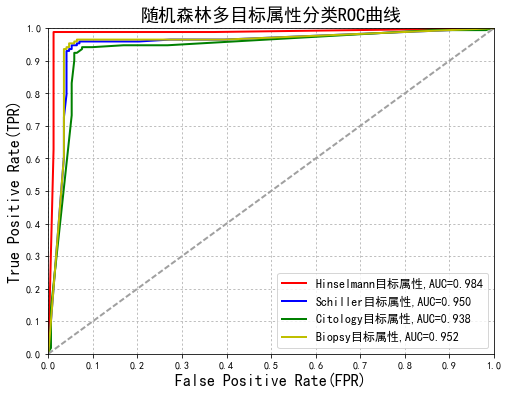

In [14]:
## 8. 画图（ROC图）
plt.figure(figsize=(8, 6), facecolor='w')
plt.plot(forest_fpr1,forest_tpr1,c='r',lw=2,label=u'Hinselmann目标属性,AUC=%.3f' % auc1)
plt.plot(forest_fpr2,forest_tpr2,c='b',lw=2,label=u'Schiller目标属性,AUC=%.3f' % auc2)
plt.plot(forest_fpr3,forest_tpr3,c='g',lw=2,label=u'Citology目标属性,AUC=%.3f' % auc3)
plt.plot(forest_fpr4,forest_tpr4,c='y',lw=2,label=u'Biopsy目标属性,AUC=%.3f' % auc4)
plt.plot((0,1),(0,1),c='#a0a0a0',lw=2,ls='--')
plt.xlim(-0.001, 1.001)
plt.ylim(-0.001, 1.001)
plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.xlabel('False Positive Rate(FPR)', fontsize=16)
plt.ylabel('True Positive Rate(TPR)', fontsize=16)
plt.grid(b=True, ls=':')
plt.legend(loc='lower right', fancybox=True, framealpha=0.8, fontsize=12)
plt.title(u'随机森林多目标属性分类ROC曲线', fontsize=18)
plt.show()

训练样本数量429，测试样本数量:429
1决策树数目，1最大深度，正确率:86.48%
1决策树数目，2最大深度，正确率:86.95%
1决策树数目，3最大深度，正确率:84.62%
1决策树数目，7最大深度，正确率:82.75%
1决策树数目，15最大深度，正确率:78.09%
50决策树数目，1最大深度，正确率:86.71%
50决策树数目，2最大深度，正确率:86.48%
50决策树数目，3最大深度，正确率:86.48%
50决策树数目，7最大深度，正确率:86.25%
50决策树数目，15最大深度，正确率:84.38%
100决策树数目，1最大深度，正确率:86.95%
100决策树数目，2最大深度，正确率:86.25%
100决策树数目，3最大深度，正确率:86.48%
100决策树数目，7最大深度，正确率:86.25%
100决策树数目，15最大深度，正确率:85.08%
500决策树数目，1最大深度，正确率:86.48%
500决策树数目，2最大深度，正确率:86.48%
500决策树数目，3最大深度，正确率:86.48%
500决策树数目，7最大深度，正确率:86.25%
500决策树数目，15最大深度，正确率:84.85%


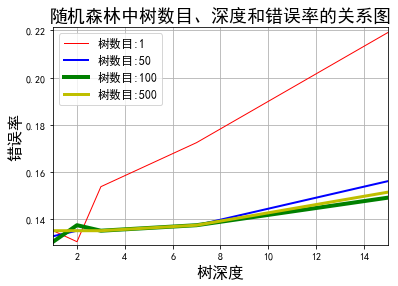

In [15]:
#比较不同树数目、树最大深度的情况下随机森林的正确率
#一般情况下，初始的随机森林树个数是100，深度1，如果需要我们再进行优化操作
x_train2,x_test2,y_train2,y_test2 = train_test_split(X, Y, test_size=0.5, random_state=0)
print ("训练样本数量%d，测试样本数量:%d" % (x_train2.shape[0], x_test2.shape[0]))
## 比较
estimators = [1,50,100,500]
depth = [1,2,3,7,15]
x1, x2 = np.meshgrid(estimators, depth)
err_list = []
for es in estimators:
    es_list = []
    for d in depth:
        tf = RandomForestClassifier(n_estimators=es, criterion='gini', max_depth=d, max_features = None, random_state=0)
        tf.fit(x_train2, y_train2)
        st = tf.score(x_test2, y_test2)
        err = 1 - st
        es_list.append(err)
        print ("%d决策树数目，%d最大深度，正确率:%.2f%%" % (es, d, st * 100))
    err_list.append(es_list)

    
## 画图
plt.figure(facecolor='w')
i = 0
colors = ['r','b','g','y']
lw = [1,2,4,3]
max_err = 0
min_err = 100
for es,l in zip(estimators,err_list):
    plt.plot(depth, l, c=colors[i], lw=lw[i], label=u'树数目:%d' % es)
    max_err = max((max(l),max_err))
    min_err = min((min(l),min_err))
    i += 1
plt.xlabel(u'树深度', fontsize=16)
plt.ylabel(u'错误率', fontsize=16)
plt.legend(loc='upper left', fancybox=True, framealpha=0.8, fontsize=12)
plt.grid(True)
plt.xlim(min(depth),max(depth))
plt.ylim(min_err * 0.99, max_err * 1.01)
plt.title(u'随机森林中树数目、深度和错误率的关系图', fontsize=18)
plt.show()